**Đề tài:** Nhận dạng chứng cứ cho phân tích cảm xúc dựa trên khía cạnh tiếng Việt. \\
**GVHD:** Nguyễn Lưu Thùy Ngân, Nguyễn Văn Kiệt, Nguyễn Đức Vũ, Lưu Thanh Sơn, Huỳnh Văn Tín, Nguyễn Thành Luân. \\
**Sinh viên thực hiện:** Trần Triệu Vũ, Phạm Đức Thể, Nguyễn Văn Hữu Nghĩa. \\
**Các pre-trained sử dụng:**
- [PhoW2V(syllable-300d)](https://drive.google.com/file/d/1R8lRuZgVtm8GUz2PHtCAQfoaaxwYrQ9o/view?usp=sharing)
- [cc.vi.300.vec](https://drive.google.com/file/d/1RZDd0saERsS_QVA28PU7OZx2NaYHrmlN/view?usp=sharing)
- [wiki.vi.vec](https://drive.google.com/file/d/1GX1LLJ7VEKLkPinjUf9sJXXtr05LVRi1/view?usp=sharing)

# Chuẩn bị dữ liệu

## Check GPU

In [ ]:
!nvidia-smi

Sat Dec 18 09:51:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    39W / 250W |   8751MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9934834818790185724
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4141739093439825795
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## Cài đặt thư viện bổ sung và kết nối drive

In [ ]:
%%capture
!pip install keras-crf
!pip install seqeval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU, Concatenate
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Dropout
from keras.initializers import Constant
from keras_crf import CRFModel
from seqeval.metrics import classification_report
from keras.utils.vis_utils import plot_model

## Load data

In [ ]:
def load_data_and_labels(filename, encoding='utf-8'): 
  sents, labels = [], [] 
  words, tags = [], [] 
  with open(filename, encoding=encoding) as f: 
    for line in f: 
      try: 
        line = line.strip() 
        if line: 
          word, tag = line.split(" ") 
          words.append(word) 
          tags.append(tag) 
        else: 
          sents.append(words) 
          labels.append(tags) 
          words, tags = [], [] 
      except Exception as e: 
        pass
  return sents, labels 

In [ ]:
train_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/train.txt') 
dev_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/dev.txt')  
test_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/test.txt')

## Lấy words và tags

In [ ]:
words = list(set(np.concatenate((np.concatenate(train_set[0]), np.concatenate(dev_set[0])))))
words.append("UNK")
words.append("ENDPAD")
tags = list(set(np.concatenate((np.concatenate(train_set[1]), np.concatenate(dev_set[1])))))

num_words = len(words)
num_tags = len(tags)

## Tạo word2idx và tag2idx

In [ ]:
word2idx = {w:i for i,w in enumerate(words)} 
tag2idx = {t:i for i,t in enumerate(tags)}

## Encoding

In [ ]:
max_len = 100
def encoding(data): 
  X = [[word2idx.get(w, num_words-2) for w in t] for t in data[0]] 
  X = pad_sequences(maxlen = max_len, sequences = X, 
                    padding = "post", value = num_words-1) 

  y = [[tag2idx[w] for w in s] for s in data[1]] 
  y = pad_sequences(maxlen=max_len, sequences=y, 
                    padding="post", value=tag2idx["O"])

  return X, y 
 
x_train, y_train = encoding(train_set) 
x_dev, y_dev = encoding(dev_set) 
x_test, y_test = encoding(test_set) 

# Không dử dụng pre-trained embedding

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
input_word = Input(shape=(max_len,), dtype="float64")

# embedding
emb = Embedding(input_dim=num_words, output_dim=300,
                    input_length=max_len)(input_word)

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model(input_word, out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(1e-2)
model.compile(optimizer=opt, metrics=['acc'])
model.summary()

Model: "crf_model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 100, 300)     3811500     ['input_40[0][0]']               
                                                                                                  
 spatial_dropout1d_67 (SpatialD  (None, 100, 300)    0           ['embedding_39[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_58 (Bidirectiona  (None, 100, 200)    320800      ['spatial_dropout1d_67

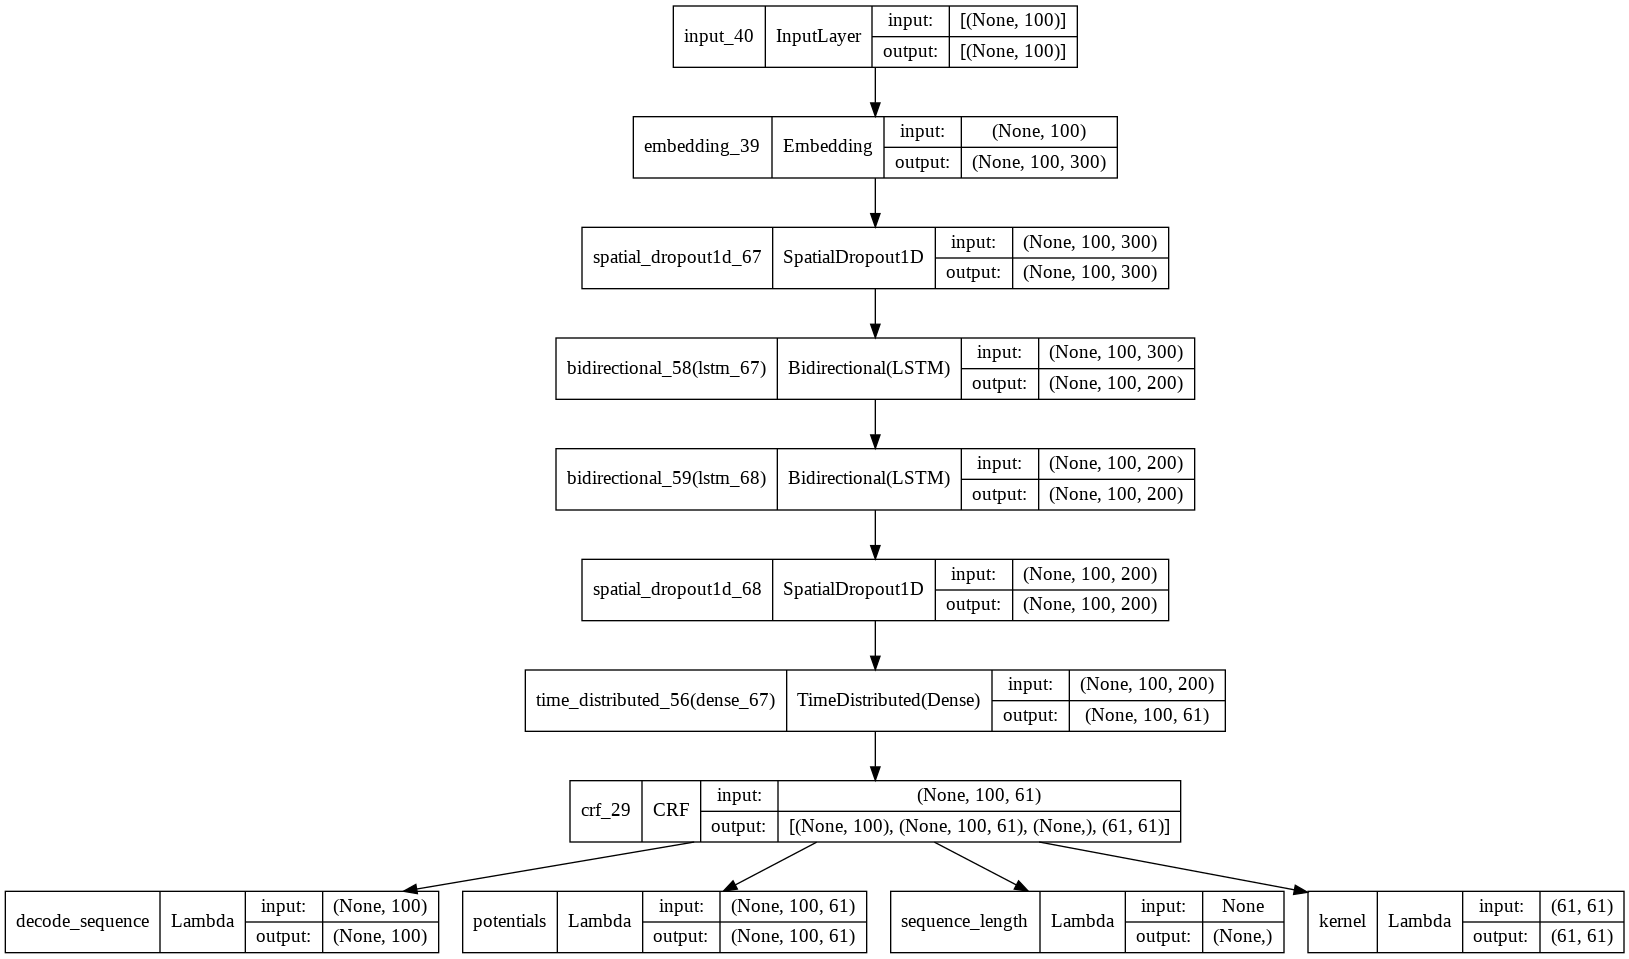

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 29s 457ms/step - decode_sequence_acc: 0.7589 - loss: 123.3947 - val_decode_sequence_acc: 0.7917 - val_loss: 76.7096
Epoch 2/30
26/26 [==============================] - 8s 318ms/step - decode_sequence_acc: 0.7899 - loss: 73.9367 - val_decode_sequence_acc: 0.8038 - val_loss: 54.9153
Epoch 3/30
26/26 [==============================] - 7s 263ms/step - decode_sequence_acc: 0.8092 - loss: 51.3362 - val_decode_sequence_acc: 0.8258 - val_loss: 38.2714
Epoch 4/30
26/26 [==============================] - 7s 257ms/step - decode_sequence_acc: 0.8389 - loss: 34.5718 - val_decode_sequence_acc: 0.8259 - val_loss: 33.0797
Epoch 5/30
26/26 [==============================] - 7s 257ms/step - decode_sequence_acc: 0.8580 - loss: 25.7355 - val_decode_sequence_acc: 0.8542 - val_loss: 24.0478
Epoch 6/30
26/26 [==============================] - 7s 258ms/step - decode_sequence_acc: 0.8697 - loss: 20.7982 - val_decode_sequence_acc: 0.8530 - val_loss: 22.5946
Ep

## Đánh giá mô hình

In [ ]:
def print_report():
  y_tr = y_test
  y_pr = model.predict(np.array(x_test))
  y_pr = y_pr[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
print_report()

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.3724    0.4157    0.3929       344
     BATTERY#NEUTRAL     0.2222    0.3158    0.2609        57
    BATTERY#POSITIVE     0.6940    0.7104    0.7021       549
     CAMERA#NEGATIVE     0.3750    0.5032    0.4298       155
      CAMERA#NEUTRAL     0.4792    0.3538    0.4071        65
     CAMERA#POSITIVE     0.6907    0.7616    0.7244       302
     DESIGN#NEGATIVE     0.2632    0.3049    0.2825        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.5822    0.6719    0.6239       253
   FEATURES#NEGATIVE     0.3816    0.4295    0.4041       454
    FEATURES#NEUTRAL     0.1724    0.1786    0.1754        28
   FEATURES#POSITIVE     0.5455    0.6055    0.5739       218
    GENERAL#NEGATIVE     0.3345    0.4196    0.3723       224
     GENERAL#NEUTRAL     0.3281    0.3500    0.3387        60
    GENERAL#POSITIVE     0.5888    0.6264    0.6070      1143
PERFORM

In [ ]:
def predict(i):
  y_pred = model.predict(np.array([x_test[i]]))
  y_pred = y_pred[0]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred[0]):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN#POSITIVE
thấy                B-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
mẫu                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	O
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
ĐMX 

# Sử dụng pre-trained PhoW2V

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/word2vec_vi_syllables_300dims.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix1 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix1[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
def model_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")

  # syllabel embedding
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                    input_length=max_len, trainable=True)(input_word)

  # model
  model = SpatialDropout1D(0.33)(syl_emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model(input_word, out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(1e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_40 (Embedding)       (None, 100, 300)     3811500     ['input_41[0][0]']               
                                                                                                  
 spatial_dropout1d_69 (SpatialD  (None, 100, 300)    0           ['embedding_40[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_60 (Bidirectiona  (None, 100, 200)    320800      ['spatial_dropout1d_69

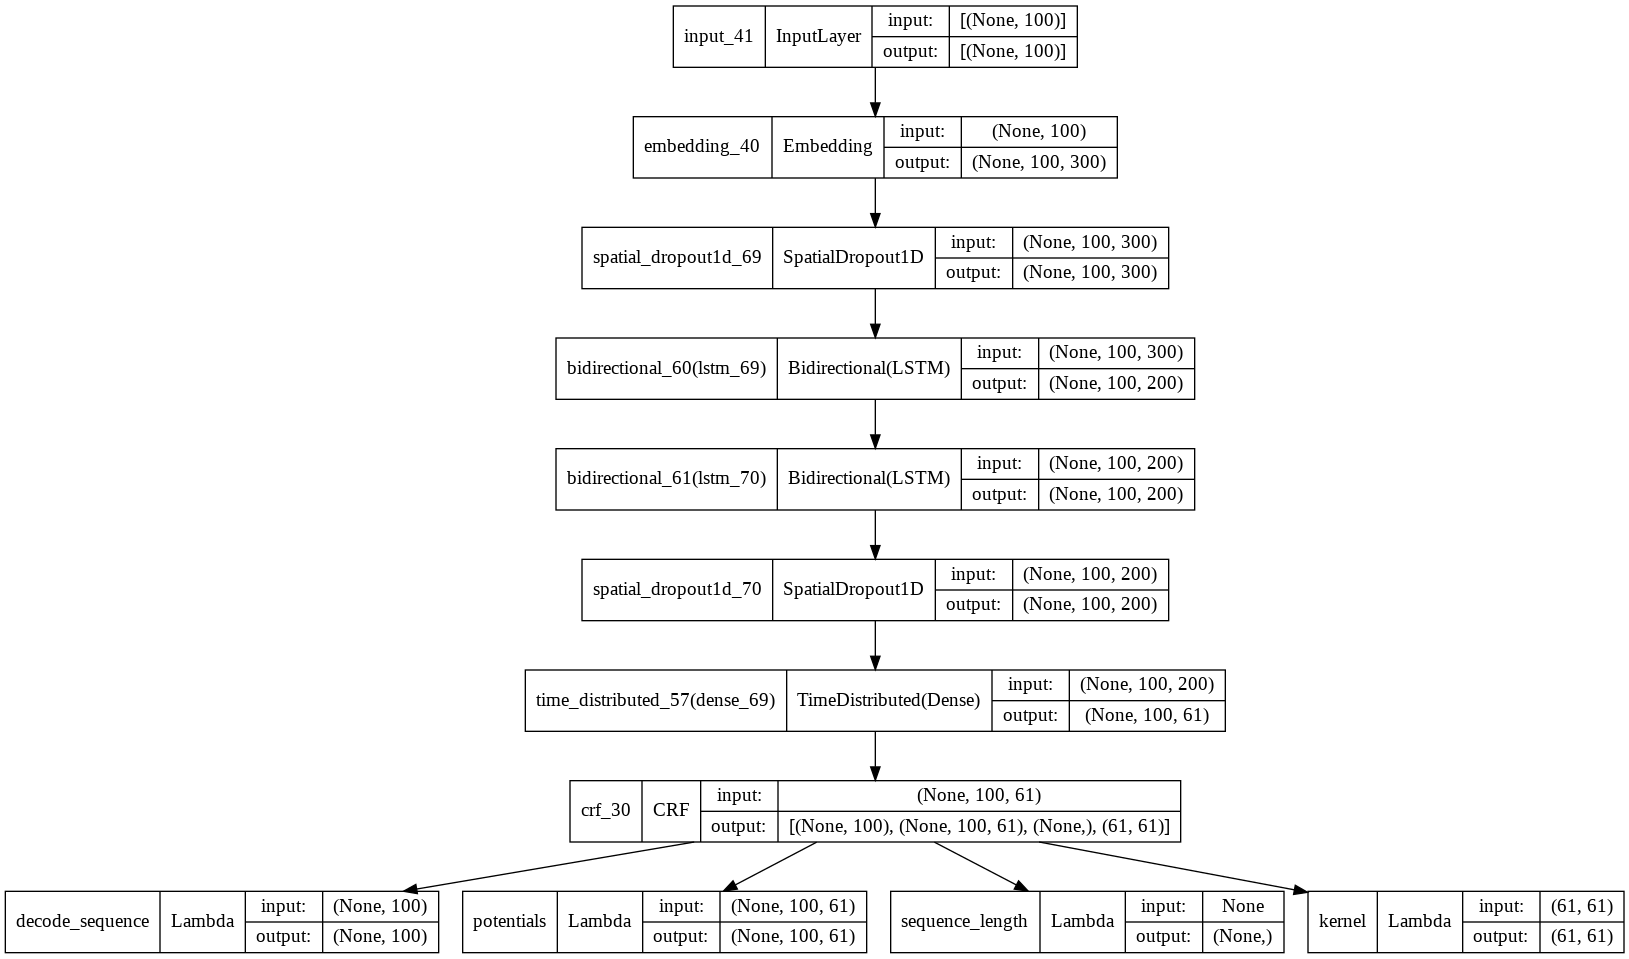

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 21s 349ms/step - decode_sequence_acc: 0.7343 - loss: 137.9908 - val_decode_sequence_acc: 0.7918 - val_loss: 76.9570
Epoch 2/30
26/26 [==============================] - 7s 260ms/step - decode_sequence_acc: 0.7885 - loss: 75.1492 - val_decode_sequence_acc: 0.7925 - val_loss: 61.6988
Epoch 3/30
26/26 [==============================] - 7s 259ms/step - decode_sequence_acc: 0.7969 - loss: 56.9979 - val_decode_sequence_acc: 0.8094 - val_loss: 44.1281
Epoch 4/30
26/26 [==============================] - 7s 257ms/step - decode_sequence_acc: 0.8183 - loss: 41.0132 - val_decode_sequence_acc: 0.8248 - val_loss: 33.6014
Epoch 5/30
26/26 [==============================] - 7s 259ms/step - decode_sequence_acc: 0.8417 - loss: 28.3645 - val_decode_sequence_acc: 0.8457 - val_loss: 24.5960
Epoch 6/30
26/26 [==============================] - 7s 258ms/step - decode_sequence_acc: 0.8521 - loss: 22.4120 - val_decode_sequence_acc: 0.8572 - val_loss: 22.4552
Ep

## Đánh giá mô hình

In [ ]:
print_report()

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.4010    0.4884    0.4404       344
     BATTERY#NEUTRAL     0.1905    0.0702    0.1026        57
    BATTERY#POSITIVE     0.6711    0.7432    0.7053       549
     CAMERA#NEGATIVE     0.4103    0.5161    0.4571       155
      CAMERA#NEUTRAL     0.4444    0.3692    0.4034        65
     CAMERA#POSITIVE     0.6788    0.7417    0.7089       302
     DESIGN#NEGATIVE     0.3095    0.3171    0.3133        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.6304    0.6877    0.6578       253
   FEATURES#NEGATIVE     0.3733    0.4185    0.3946       454
    FEATURES#NEUTRAL     0.2500    0.1429    0.1818        28
   FEATURES#POSITIVE     0.4922    0.5780    0.5316       218
    GENERAL#NEGATIVE     0.3388    0.4643    0.3917       224
     GENERAL#NEUTRAL     0.5333    0.4000    0.4571        60
    GENERAL#POSITIVE     0.6090    0.6159    0.6124      1143
PERFORM

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN#POSITIVE
thấy                B-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
mẫu                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	B-GENERAL#POSITIVE
em                  I-SER&ACC#POSITIVE  	I-GENERAL#POSITIVE
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#

# Sử dụng pre-trained cc.vi.300.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/cc.vi.300.vec')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix2 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix2[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_41 (Embedding)       (None, 100, 300)     3811500     ['input_42[0][0]']               
                                                                                                  
 spatial_dropout1d_71 (SpatialD  (None, 100, 300)    0           ['embedding_41[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_62 (Bidirectiona  (None, 100, 200)    320800      ['spatial_dropout1d_71

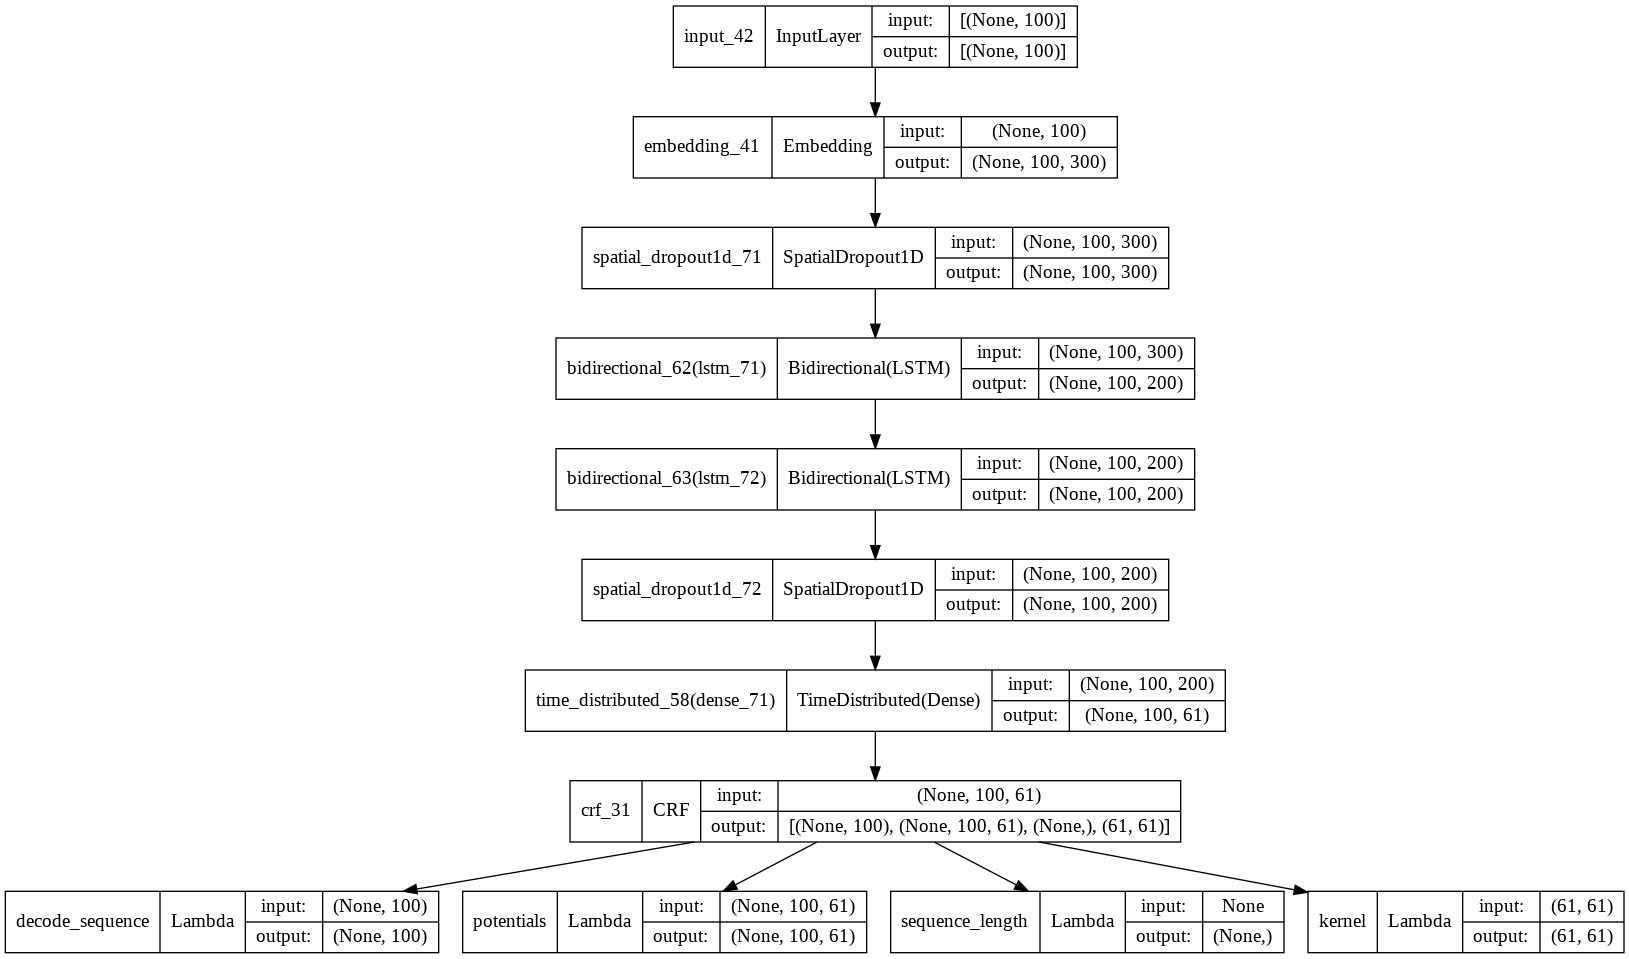

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 21s 344ms/step - decode_sequence_acc: 0.7579 - loss: 131.8948 - val_decode_sequence_acc: 0.7918 - val_loss: 76.9705
Epoch 2/30
26/26 [==============================] - 7s 254ms/step - decode_sequence_acc: 0.7903 - loss: 73.9552 - val_decode_sequence_acc: 0.8016 - val_loss: 55.4996
Epoch 3/30
26/26 [==============================] - 7s 254ms/step - decode_sequence_acc: 0.8107 - loss: 51.4762 - val_decode_sequence_acc: 0.8223 - val_loss: 38.4908
Epoch 4/30
26/26 [==============================] - 7s 254ms/step - decode_sequence_acc: 0.8354 - loss: 35.2361 - val_decode_sequence_acc: 0.8446 - val_loss: 28.6773
Epoch 5/30
26/26 [==============================] - 7s 253ms/step - decode_sequence_acc: 0.8552 - loss: 25.7961 - val_decode_sequence_acc: 0.8570 - val_loss: 23.4625
Epoch 6/30
26/26 [==============================] - 7s 255ms/step - decode_sequence_acc: 0.8651 - loss: 20.8931 - val_decode_sequence_acc: 0.8528 - val_loss: 25.1015
Ep

## Đánh giá mô hình

In [ ]:
print_report()

                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.4234    0.4419    0.4324       344
     BATTERY#NEUTRAL     0.1587    0.3509    0.2186        57
    BATTERY#POSITIVE     0.7295    0.6976    0.7132       549
     CAMERA#NEGATIVE     0.4302    0.4968    0.4611       155
      CAMERA#NEUTRAL     0.3780    0.4769    0.4218        65
     CAMERA#POSITIVE     0.7042    0.7252    0.7145       302
     DESIGN#NEGATIVE     0.2674    0.2805    0.2738        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.6338    0.7115    0.6704       253
   FEATURES#NEGATIVE     0.4186    0.3965    0.4072       454
    FEATURES#NEUTRAL     0.1905    0.2857    0.2286        28
   FEATURES#POSITIVE     0.5728    0.5596    0.5661       218
    GENERAL#NEGATIVE     0.3953    0.4554    0.4232       224
     GENERAL#NEUTRAL     0.4655    0.4500    0.4576        60
    GENERAL#POSITIVE     0.6031    0.6220    0.6124      1143
PERFORM

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN#POSITIVE   	O
mẫu                 I-DESIGN#POSITIVE   	B-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
ĐMX               

# Sử dụng pre-trained wiki.vi.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/wiki.vi.vec')
for line in f:
    values = line.split(' ')[:-1]
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix3 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix3[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix3[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_57 (Embedding)       (None, 100, 300)     3811500     ['input_58[0][0]']               
                                                                                                  
 spatial_dropout1d_97 (SpatialD  (None, 100, 300)    0           ['embedding_57[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_82 (Bidirectiona  (None, 100, 200)    320800      ['spatial_dropout1d_97

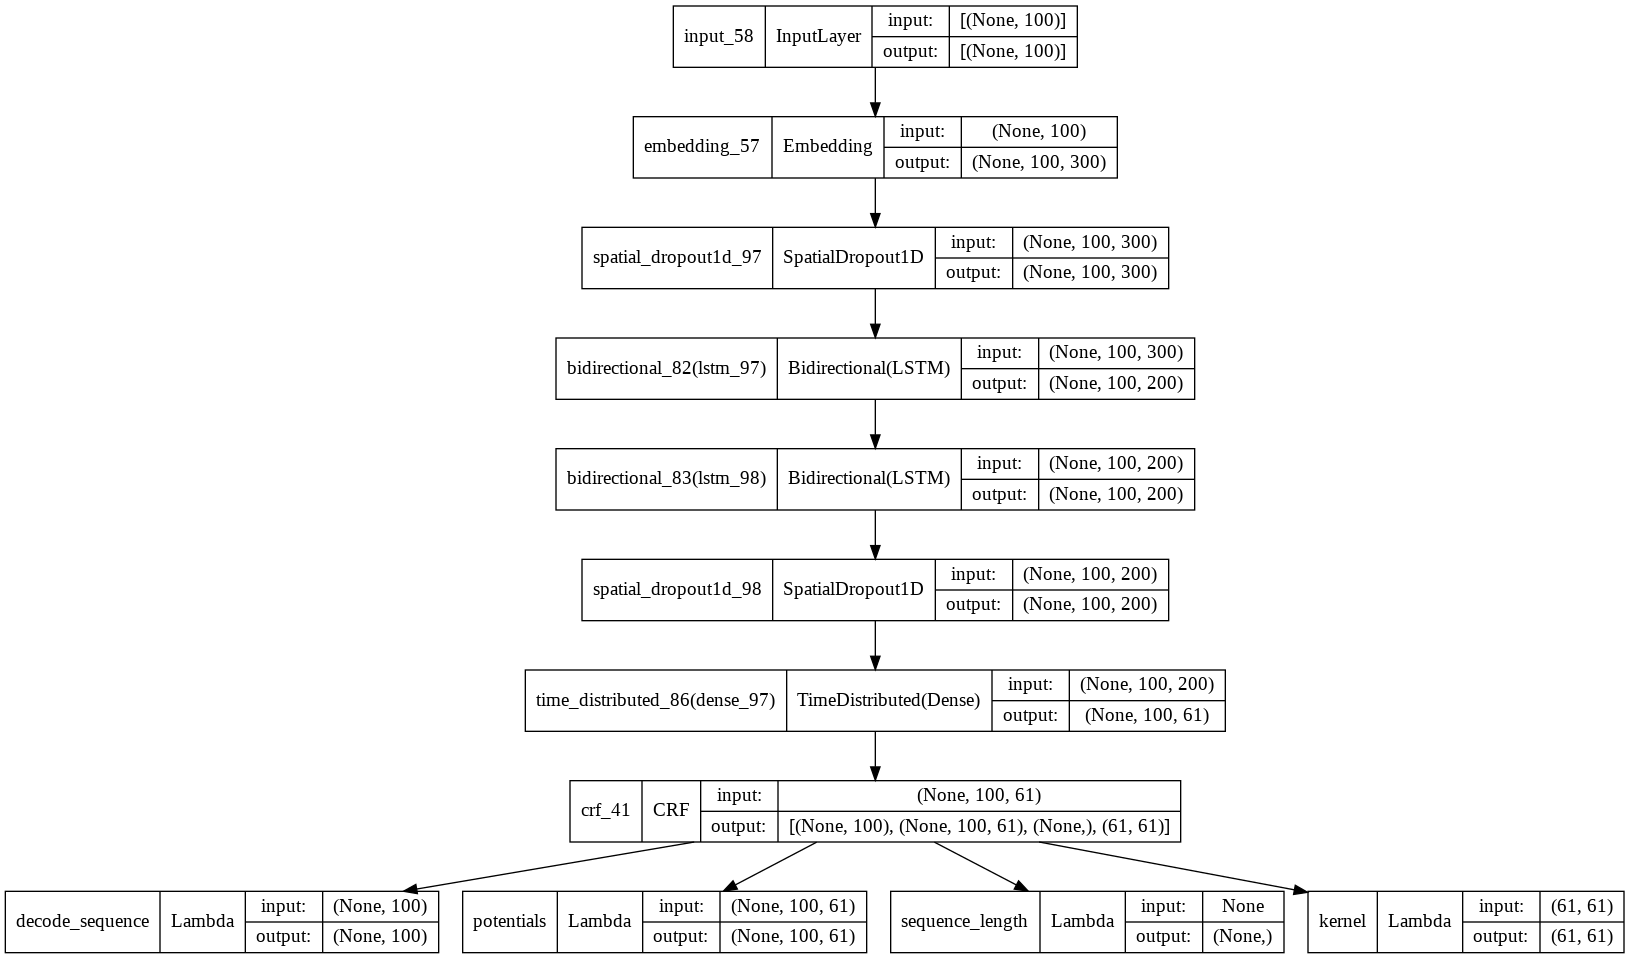

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 20s 346ms/step - decode_sequence_acc: 0.7584 - loss: 128.3832 - val_decode_sequence_acc: 0.7918 - val_loss: 74.3572
Epoch 2/30
26/26 [==============================] - 7s 255ms/step - decode_sequence_acc: 0.7875 - loss: 73.7897 - val_decode_sequence_acc: 0.7840 - val_loss: 59.1102
Epoch 3/30
26/26 [==============================] - 7s 254ms/step - decode_sequence_acc: 0.8014 - loss: 54.9939 - val_decode_sequence_acc: 0.8130 - val_loss: 40.2695
Epoch 4/30
26/26 [==============================] - 7s 256ms/step - decode_sequence_acc: 0.8260 - loss: 37.8521 - val_decode_sequence_acc: 0.8398 - val_loss: 28.7742
Epoch 5/30
26/26 [==============================] - 7s 257ms/step - decode_sequence_acc: 0.8425 - loss: 28.3397 - val_decode_sequence_acc: 0.8493 - val_loss: 23.1411
Epoch 6/30
26/26 [==============================] - 7s 256ms/step - decode_sequence_acc: 0.8499 - loss: 23.0460 - val_decode_sequence_acc: 0.8523 - val_loss: 22.7299
Ep

## Đánh giá mô hình

In [ ]:
print_report()

                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.4382    0.4535    0.4457       344
     BATTERY#NEUTRAL     0.2115    0.3860    0.2733        57
    BATTERY#POSITIVE     0.7495    0.6648    0.7046       549
     CAMERA#NEGATIVE     0.4830    0.5484    0.5136       155
      CAMERA#NEUTRAL     0.5098    0.4000    0.4483        65
     CAMERA#POSITIVE     0.7482    0.6987    0.7226       302
     DESIGN#NEGATIVE     0.3333    0.2439    0.2817        82
      DESIGN#NEUTRAL     0.0769    0.0833    0.0800        12
     DESIGN#POSITIVE     0.6444    0.6877    0.6654       253
   FEATURES#NEGATIVE     0.4739    0.4207    0.4457       454
    FEATURES#NEUTRAL     0.3000    0.2143    0.2500        28
   FEATURES#POSITIVE     0.6055    0.6055    0.6055       218
    GENERAL#NEGATIVE     0.4356    0.3929    0.4131       224
     GENERAL#NEUTRAL     0.6286    0.3667    0.4632        60
    GENERAL#POSITIVE     0.6432    0.6168    0.6297      1143
PERFORM

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN#POSITIVE   	O
mẫu                 I-DESIGN#POSITIVE   	B-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	O
ứng                 I-FEATURES#POSITIVE 	O
mượt                I-FEATURES#POSITIVE 	O
được                B-SER&ACC#POSITIVE  	O
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
ĐMX                 I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
tư                  I-SER&ACC#

# Kết hợp với char-LSTM

## Char encode

In [ ]:
max_len_char = 15
chars = set([c for w in words for c in w])
n_chars = len(chars) + 2

In [ ]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [ ]:
def char_encode(data):
  X_char = []
  sent_idx = 0
  for sentence in data:
      sent_seq = []
      for i in range(max_len):
          word_seq = []
          for j in range(max_len_char):
              try:
                  word_seq.append(char2idx.get(data[sent_idx][i][j], char2idx.get('UNK')))
              except:
                  word_seq.append(char2idx.get('PAD'))
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
      sent_idx += 1
  return X_char

In [ ]:
x_char_train = char_encode(train_set[0])
x_char_dev = char_encode(dev_set[0])
x_char_test = char_encode(test_set[0])

In [ ]:
x_char_train = np.array(x_char_train).reshape((len(x_char_train), max_len, max_len_char))
x_char_dev = np.array(x_char_dev).reshape((len(x_char_dev), max_len, max_len_char))
x_char_test = np.array(x_char_test).reshape((len(x_char_test), max_len, max_len_char))

## Không sử dụng pre-trained embedding

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
# syllabel embedding
input_word = Input(shape=(max_len,), dtype="float64")
syl_emb = Embedding(input_dim=num_words, output_dim=100,
                    input_length=max_len)(input_word)

# character embedding
input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                           input_length=max_len_char))(input_char)
char_emb = Dropout(0.33)(char_emb)
char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
char_emb = SpatialDropout1D(0.33)(char_emb)
char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

# Concatenate
emb = Concatenate()([syl_emb, char_emb])

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model([input_word, input_char], out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(1e-2)
model.compile(optimizer=opt, metrics=['acc'])

In [ ]:
model.summary()

Model: "crf_model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_60 (TimeDistr  (None, 100, 15, 300  102000     ['input_45[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_60[0][0]']    
                                )                                                                 
                                                                                       

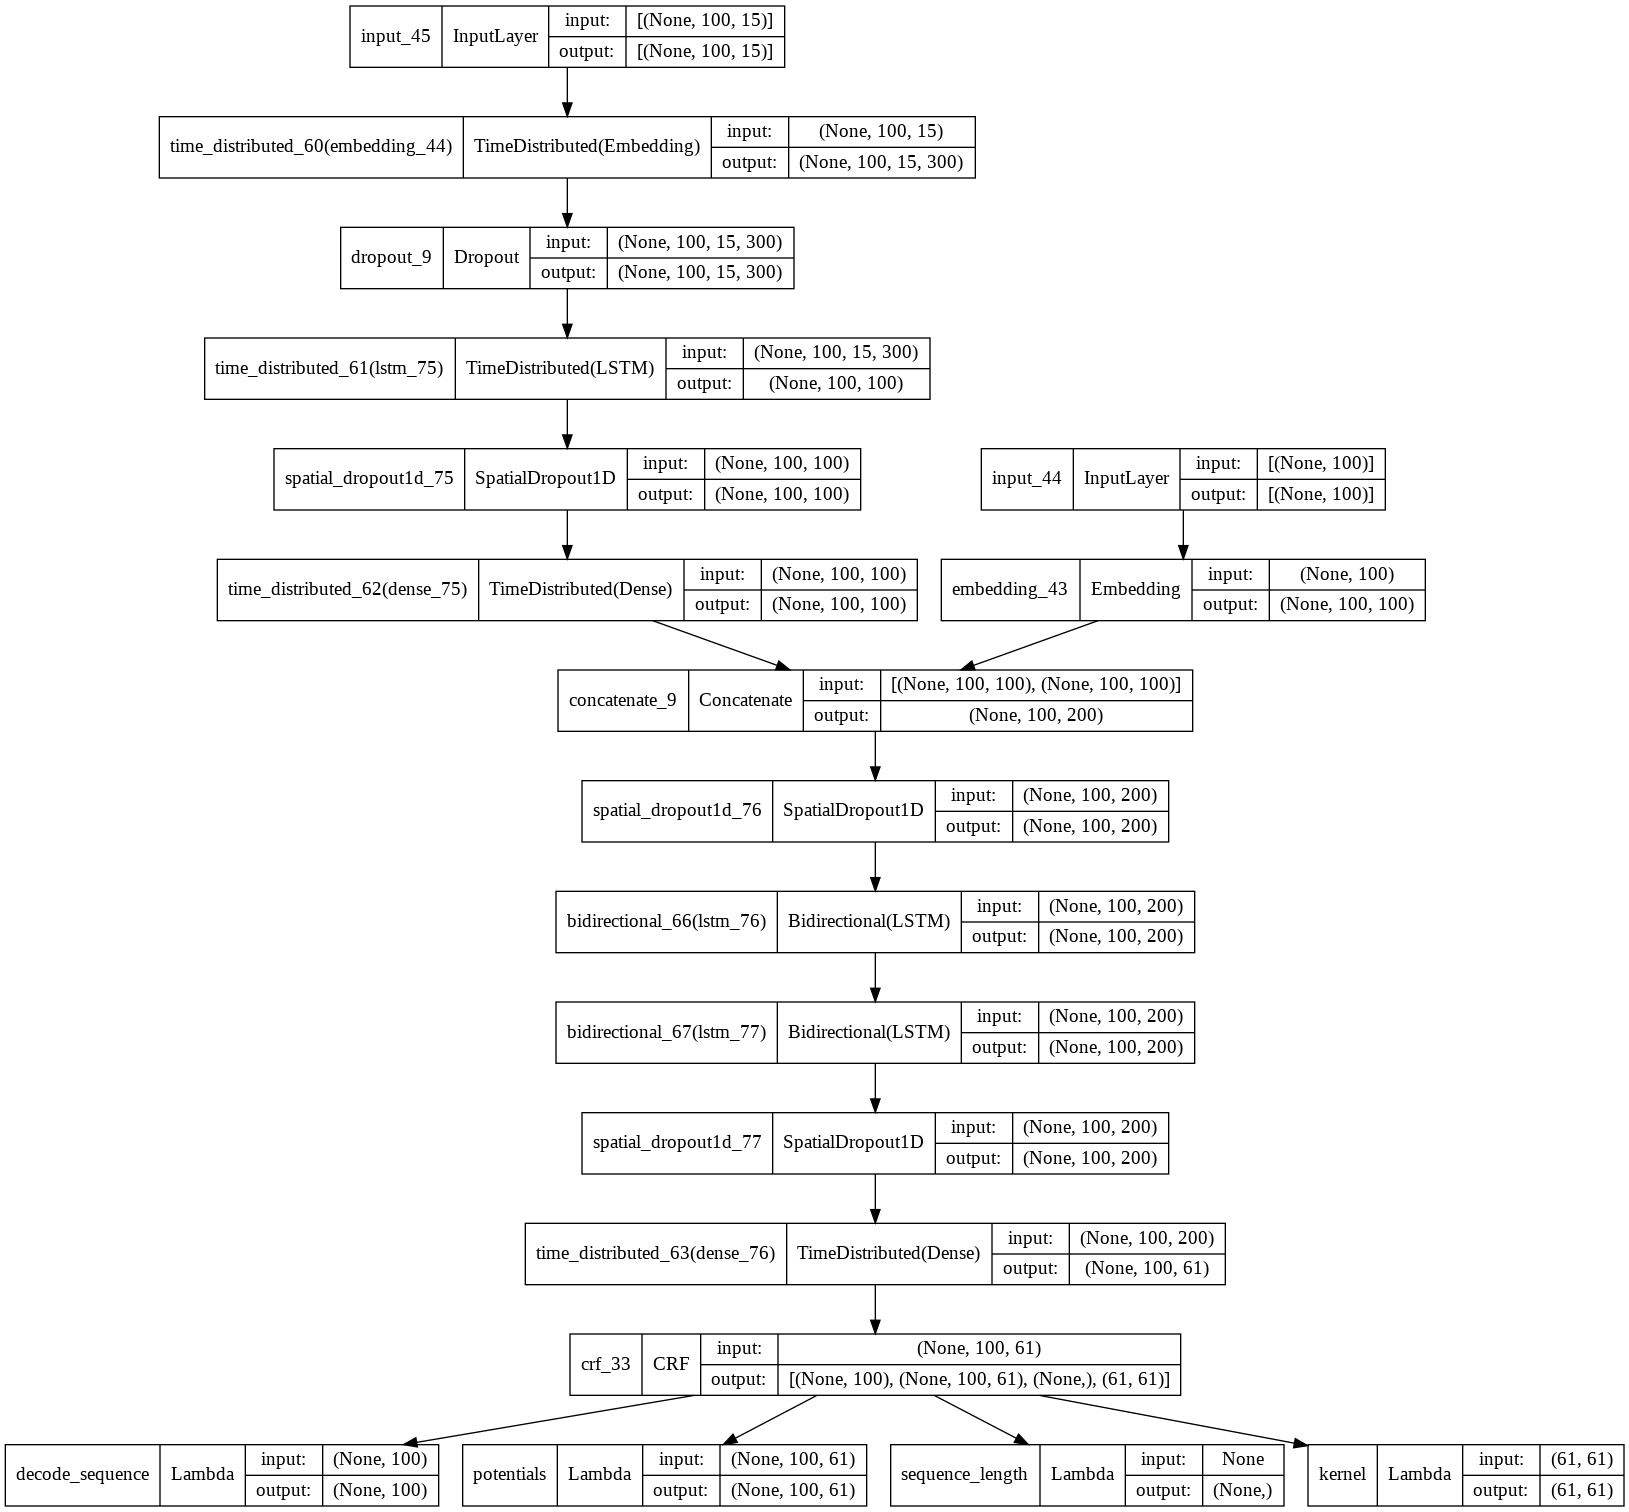

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 28s 551ms/step - decode_sequence_acc: 0.7555 - loss: 139.2215 - val_decode_sequence_acc: 0.7918 - val_loss: 92.3416
Epoch 2/30
26/26 [==============================] - 12s 443ms/step - decode_sequence_acc: 0.7886 - loss: 82.0900 - val_decode_sequence_acc: 0.7915 - val_loss: 65.9607
Epoch 3/30
26/26 [==============================] - 12s 444ms/step - decode_sequence_acc: 0.7859 - loss: 65.6509 - val_decode_sequence_acc: 0.7924 - val_loss: 52.5366
Epoch 4/30
26/26 [==============================] - 12s 444ms/step - decode_sequence_acc: 0.7859 - loss: 53.5436 - val_decode_sequence_acc: 0.7914 - val_loss: 43.9254
Epoch 5/30
26/26 [==============================] - 12s 443ms/step - decode_sequence_acc: 0.7878 - loss: 44.0803 - val_decode_sequence_acc: 0.7862 - val_loss: 37.2607
Epoch 6/30
26/26 [==============================] - 12s 447ms/step - decode_sequence_acc: 0.7924 - loss: 36.2898 - val_decode_sequence_acc: 0.7967 - val_loss: 32.49

### Đánh giá mô hình

In [ ]:
def cprint_report():
  y_tr = y_test
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
cprint_report()

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.3668    0.4564    0.4067       344
     BATTERY#NEUTRAL     0.0000    0.0000    0.0000        57
    BATTERY#POSITIVE     0.6890    0.7104    0.6996       549
     CAMERA#NEGATIVE     0.4464    0.4839    0.4644       155
      CAMERA#NEUTRAL     0.3571    0.3846    0.3704        65
     CAMERA#POSITIVE     0.7152    0.7649    0.7392       302
     DESIGN#NEGATIVE     0.2609    0.2195    0.2384        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.5876    0.6759    0.6287       253
   FEATURES#NEGATIVE     0.4105    0.4141    0.4123       454
    FEATURES#NEUTRAL     0.1579    0.1071    0.1277        28
   FEATURES#POSITIVE     0.5593    0.6055    0.5815       218
    GENERAL#NEGATIVE     0.3322    0.4375    0.3776       224
     GENERAL#NEUTRAL     0.3108    0.3833    0.3433        60
    GENERAL#POSITIVE     0.6173    0.5941    0.6054      1143
PERFORM

In [ ]:
def cpredict(i):
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]
  y_pred = y_pr[i]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN#POSITIVE
thấy                B-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
mẫu                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
em                  I-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&AC

## Sử dụng pre-trained PhoW2V

### Xây dựng và huấn luyện mô hình

In [ ]:
# syllabel embedding
def cmodel_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                      input_length=max_len, trainable=True)(input_word)

  # character embedding
  input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
  char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                            input_length=max_len_char))(input_char)
  char_emb = Dropout(0.33)(char_emb)
  char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
  char_emb = SpatialDropout1D(0.33)(char_emb)
  char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

  # Concatenate
  emb = Concatenate()([syl_emb, char_emb])

  # model
  model = SpatialDropout1D(0.33)(emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model([input_word, input_char], out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(2e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_64 (TimeDistr  (None, 100, 15, 300  102000     ['input_47[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_10 (Dropout)           (None, 100, 15, 300  0           ['time_distributed_64[0][0]']    
                                )                                                                 
                                                                                       

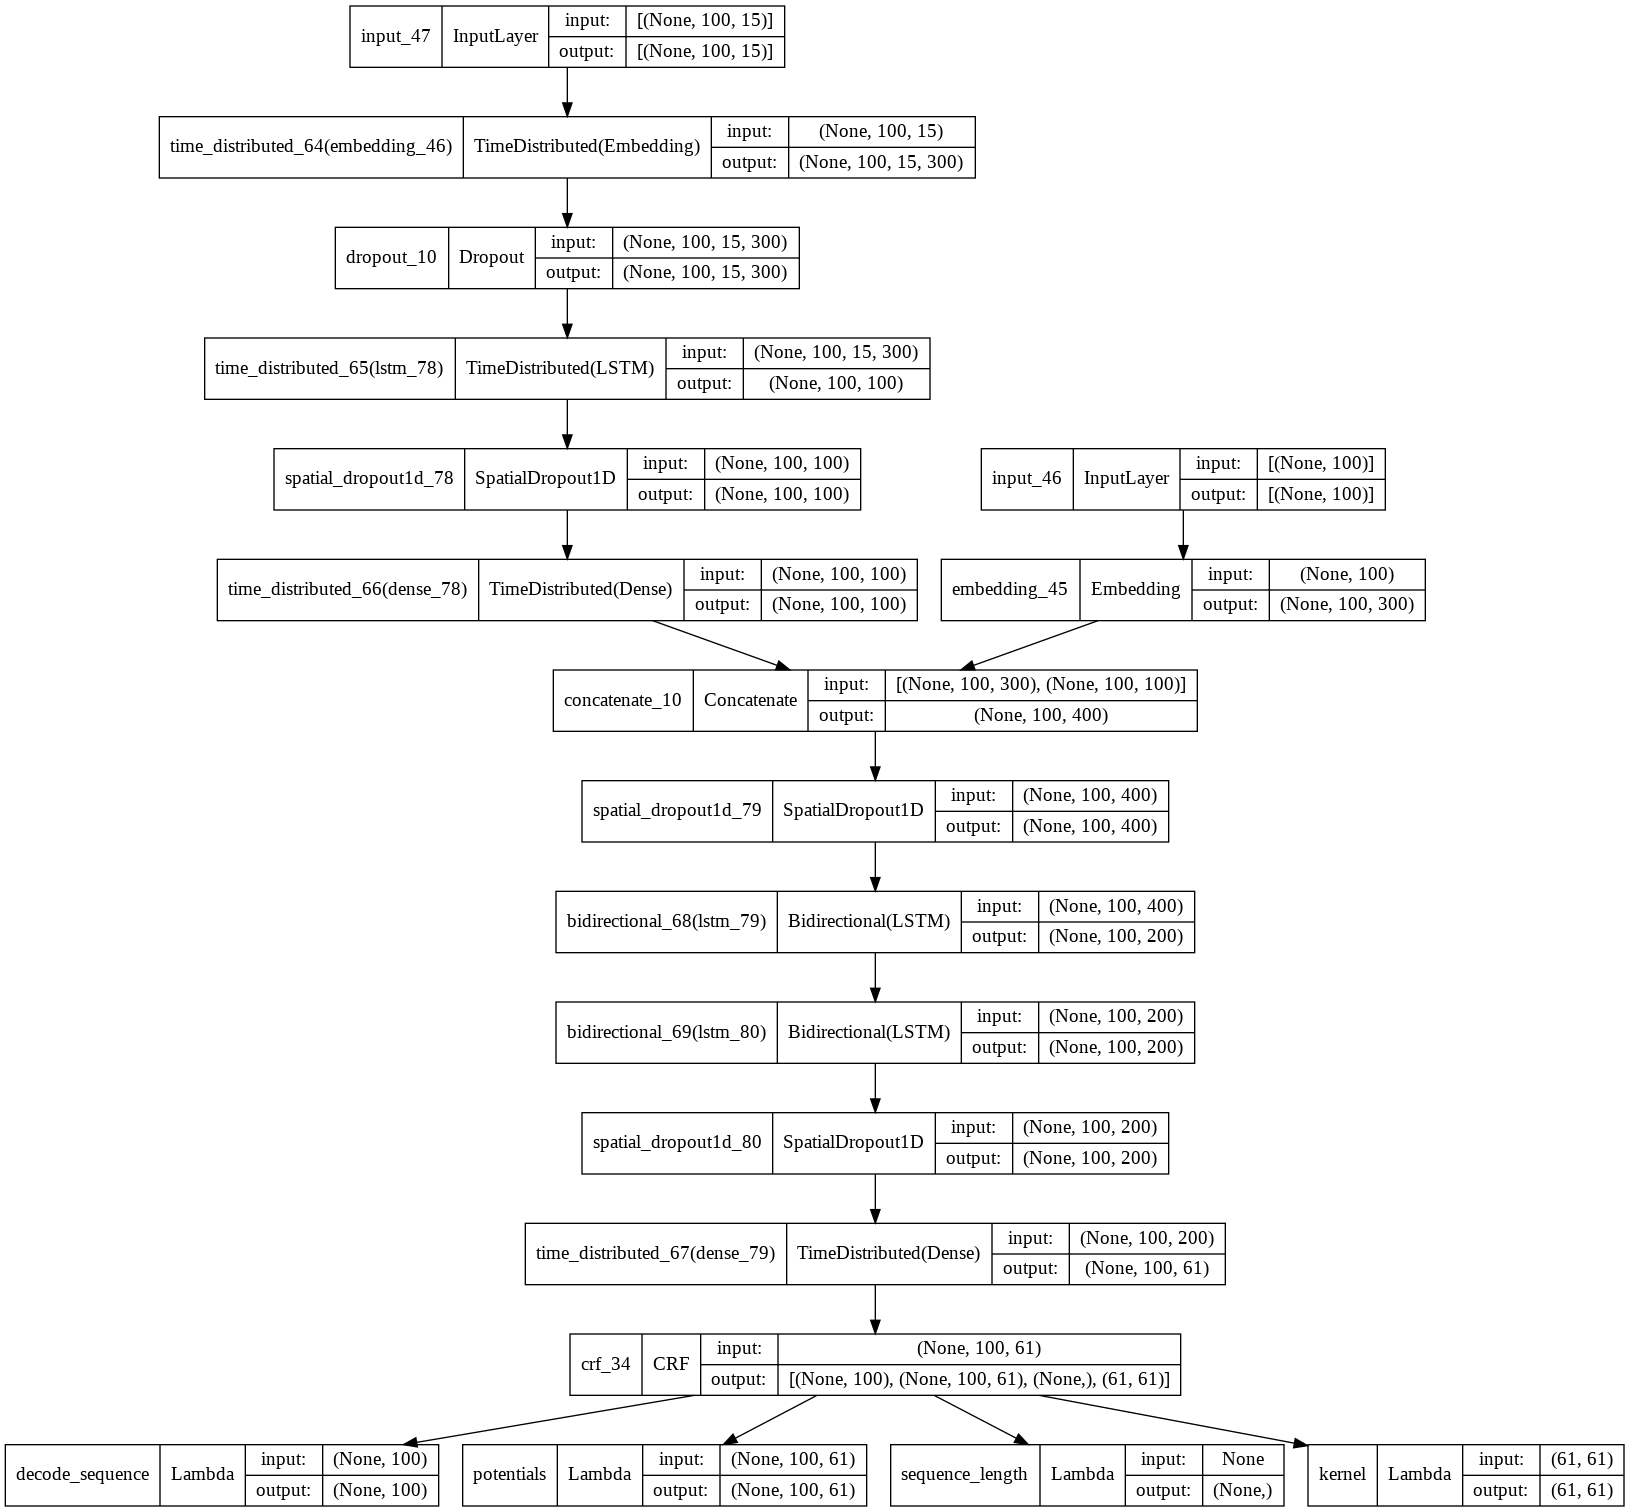

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 28s 558ms/step - decode_sequence_acc: 0.7557 - loss: 157.5063 - val_decode_sequence_acc: 0.7918 - val_loss: 93.9276
Epoch 2/30
26/26 [==============================] - 12s 453ms/step - decode_sequence_acc: 0.7888 - loss: 79.6666 - val_decode_sequence_acc: 0.7932 - val_loss: 51.6158
Epoch 3/30
26/26 [==============================] - 12s 454ms/step - decode_sequence_acc: 0.7925 - loss: 47.6473 - val_decode_sequence_acc: 0.8009 - val_loss: 36.2799
Epoch 4/30
26/26 [==============================] - 12s 452ms/step - decode_sequence_acc: 0.8044 - loss: 31.8891 - val_decode_sequence_acc: 0.8072 - val_loss: 25.8600
Epoch 5/30
26/26 [==============================] - 12s 452ms/step - decode_sequence_acc: 0.8150 - loss: 23.4707 - val_decode_sequence_acc: 0.8344 - val_loss: 24.1234
Epoch 6/30
26/26 [==============================] - 12s 452ms/step - decode_sequence_acc: 0.8220 - loss: 18.1100 - val_decode_sequence_acc: 0.8245 - val_loss: 16.44

### Đánh giá mô hình

In [ ]:
cprint_report()

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.4108    0.4419    0.4258       344
     BATTERY#NEUTRAL     0.2439    0.3509    0.2878        57
    BATTERY#POSITIVE     0.7201    0.7359    0.7279       549
     CAMERA#NEGATIVE     0.4596    0.4774    0.4684       155
      CAMERA#NEUTRAL     0.4510    0.3538    0.3966        65
     CAMERA#POSITIVE     0.6875    0.7649    0.7241       302
     DESIGN#NEGATIVE     0.1780    0.2561    0.2100        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.5803    0.6996    0.6344       253
   FEATURES#NEGATIVE     0.3996    0.3943    0.3969       454
    FEATURES#NEUTRAL     0.3750    0.1071    0.1667        28
   FEATURES#POSITIVE     0.5333    0.6239    0.5751       218
    GENERAL#NEGATIVE     0.3801    0.4598    0.4162       224
     GENERAL#NEUTRAL     0.4600    0.3833    0.4182        60
    GENERAL#POSITIVE     0.6024    0.6150    0.6087      1143
PERFORM

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN#POSITIVE
thấy                B-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
mẫu                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER

## Sử dụng pre-trained cc.vi.300.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_68 (TimeDistr  (None, 100, 15, 300  102000     ['input_49[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 100, 15, 300  0           ['time_distributed_68[0][0]']    
                                )                                                                 
                                                                                       

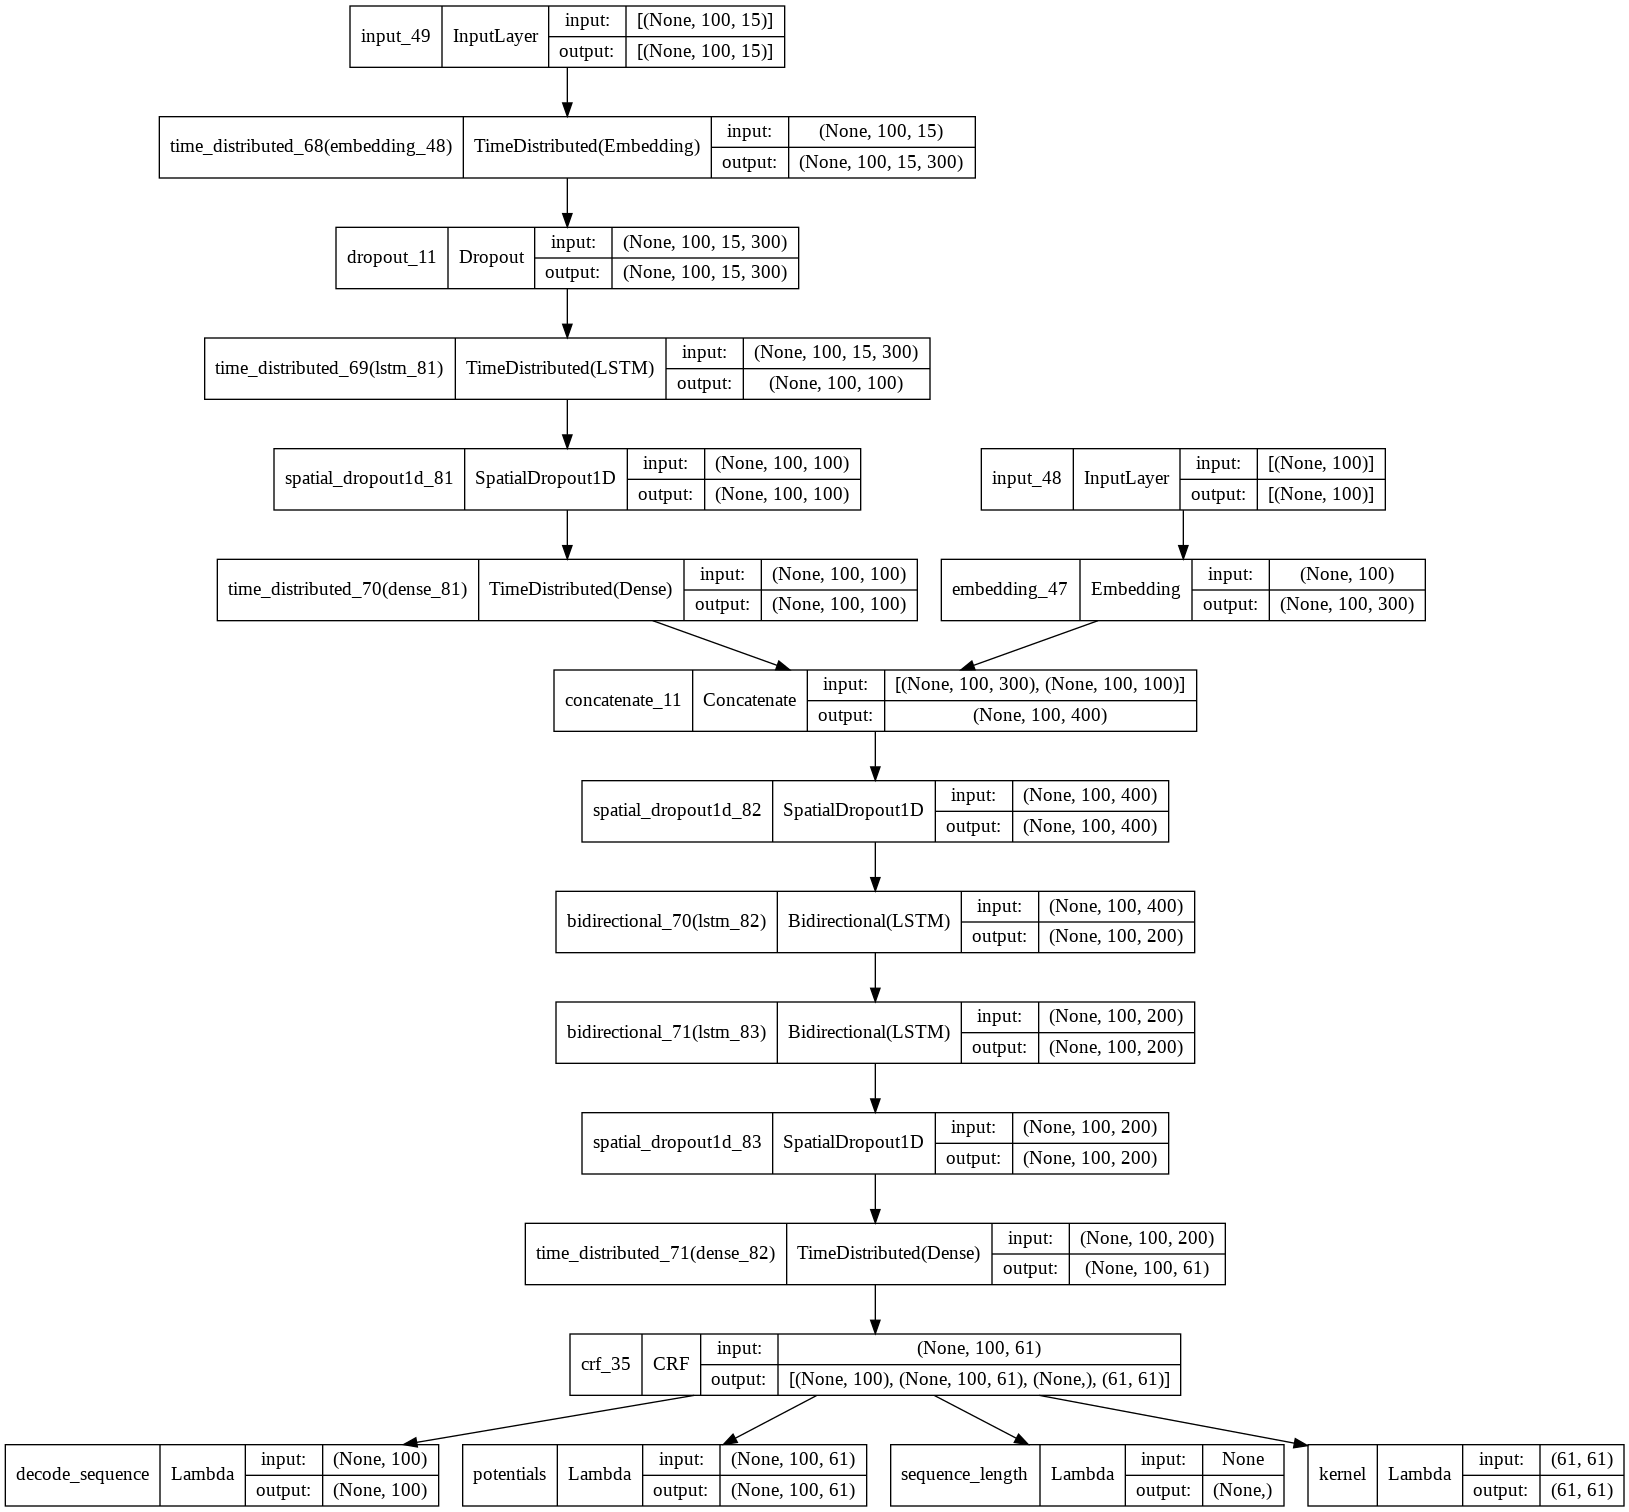

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 29s 564ms/step - decode_sequence_acc: 0.7075 - loss: 156.9292 - val_decode_sequence_acc: 0.7918 - val_loss: 72.4331
Epoch 2/30
26/26 [==============================] - 12s 453ms/step - decode_sequence_acc: 0.7877 - loss: 67.5196 - val_decode_sequence_acc: 0.7919 - val_loss: 52.3016
Epoch 3/30
26/26 [==============================] - 12s 453ms/step - decode_sequence_acc: 0.7889 - loss: 48.3441 - val_decode_sequence_acc: 0.7959 - val_loss: 35.9367
Epoch 4/30
26/26 [==============================] - 12s 451ms/step - decode_sequence_acc: 0.7955 - loss: 34.3767 - val_decode_sequence_acc: 0.8042 - val_loss: 26.3242
Epoch 5/30
26/26 [==============================] - 12s 454ms/step - decode_sequence_acc: 0.8051 - loss: 24.8425 - val_decode_sequence_acc: 0.8116 - val_loss: 22.4170
Epoch 6/30
26/26 [==============================] - 12s 451ms/step - decode_sequence_acc: 0.8095 - loss: 19.5707 - val_decode_sequence_acc: 0.8217 - val_loss: 23.85

### Đánh giá mô hình

In [ ]:
cprint_report()

                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.4457    0.4535    0.4496       344
     BATTERY#NEUTRAL     0.1901    0.4035    0.2584        57
    BATTERY#POSITIVE     0.7056    0.7158    0.7107       549
     CAMERA#NEGATIVE     0.4066    0.4774    0.4392       155
      CAMERA#NEUTRAL     0.5641    0.3385    0.4231        65
     CAMERA#POSITIVE     0.6398    0.7881    0.7062       302
     DESIGN#NEGATIVE     0.2273    0.2439    0.2353        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.5566    0.6996    0.6200       253
   FEATURES#NEGATIVE     0.4187    0.4141    0.4164       454
    FEATURES#NEUTRAL     0.5000    0.1071    0.1765        28
   FEATURES#POSITIVE     0.4437    0.6147    0.5154       218
    GENERAL#NEGATIVE     0.3422    0.4598    0.3924       224
     GENERAL#NEUTRAL     0.3750    0.3500    0.3621        60
    GENERAL#POSITIVE     0.5516    0.6360    0.5908      1143
PERFORM

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN#POSITIVE   	O
mẫu                 I-DESIGN#POSITIVE   	B-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
ĐMX               

## Sử dụng pre-trained wiki.vi.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_82 (TimeDistr  (None, 100, 15, 300  102000     ['input_57[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_14 (Dropout)           (None, 100, 15, 300  0           ['time_distributed_82[0][0]']    
                                )                                                                 
                                                                                       

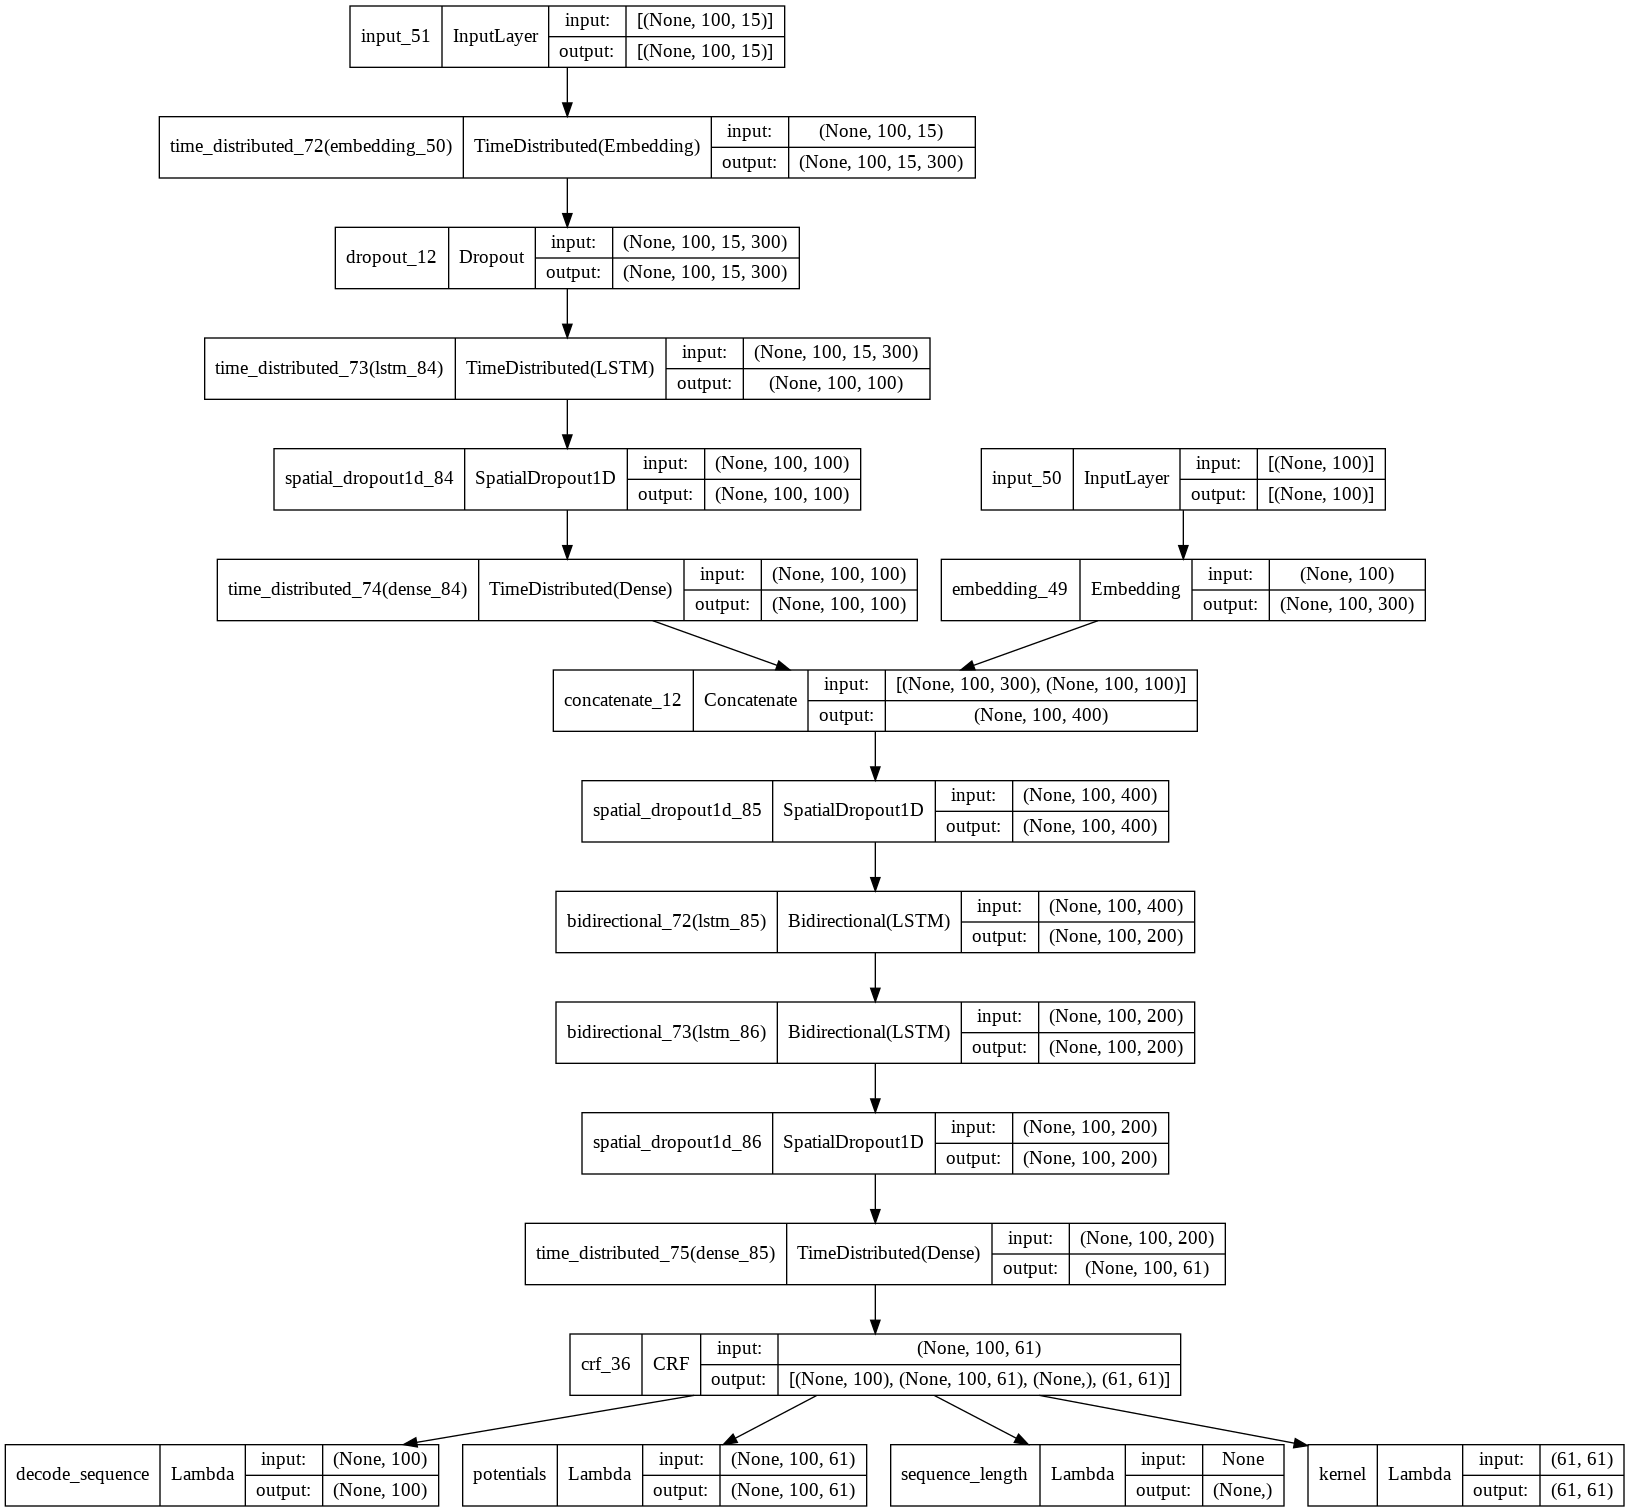

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 28s 555ms/step - decode_sequence_acc: 0.6958 - loss: 158.0415 - val_decode_sequence_acc: 0.7918 - val_loss: 102.5759
Epoch 2/30
26/26 [==============================] - 12s 455ms/step - decode_sequence_acc: 0.7889 - loss: 74.7538 - val_decode_sequence_acc: 0.7918 - val_loss: 65.3576
Epoch 3/30
26/26 [==============================] - 12s 456ms/step - decode_sequence_acc: 0.7890 - loss: 54.9108 - val_decode_sequence_acc: 0.7914 - val_loss: 45.6073
Epoch 4/30
26/26 [==============================] - 12s 454ms/step - decode_sequence_acc: 0.7904 - loss: 41.3051 - val_decode_sequence_acc: 0.7954 - val_loss: 33.0175
Epoch 5/30
26/26 [==============================] - 12s 453ms/step - decode_sequence_acc: 0.7944 - loss: 31.3945 - val_decode_sequence_acc: 0.7992 - val_loss: 25.1956
Epoch 6/30
26/26 [==============================] - 12s 451ms/step - decode_sequence_acc: 0.8021 - loss: 23.6454 - val_decode_sequence_acc: 0.8045 - val_loss: 20.3

### Đánh giá mô hình

In [ ]:
cprint_report()

                      precision    recall  f1-score   support

    BATTERY#NEGATIVE     0.3871    0.4535    0.4177       344
     BATTERY#NEUTRAL     0.7500    0.1053    0.1846        57
    BATTERY#POSITIVE     0.6740    0.7268    0.6994       549
     CAMERA#NEGATIVE     0.3944    0.4581    0.4239       155
      CAMERA#NEUTRAL     0.4815    0.4000    0.4370        65
     CAMERA#POSITIVE     0.6755    0.7583    0.7145       302
     DESIGN#NEGATIVE     0.2283    0.2561    0.2414        82
      DESIGN#NEUTRAL     0.0000    0.0000    0.0000        12
     DESIGN#POSITIVE     0.5886    0.6957    0.6377       253
   FEATURES#NEGATIVE     0.4360    0.4273    0.4316       454
    FEATURES#NEUTRAL     0.2041    0.3571    0.2597        28
   FEATURES#POSITIVE     0.5739    0.6055    0.5893       218
    GENERAL#NEGATIVE     0.3529    0.4554    0.3977       224
     GENERAL#NEUTRAL     0.3889    0.3500    0.3684        60
    GENERAL#POSITIVE     0.5763    0.6115    0.5934      1143
PERFORM

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-DESIGN#POSITIVE
thấy                B-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
mẫu                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	B-FEATURES#POSITIVE
ứng                 I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
mượt                I-FEATURES#POSITIVE 	I-FEATURES#POSITIVE
được                B-SER&ACC#POSITIVE  	I-FEATURES#POSITIVE
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER

# Chạy predict trên mô hình chỉ sử dụng pre-trained wiki.vi.vec

In [ ]:
predict(1)

Word                True                	 Pred

------------------------------
Mua                 O                   	O
cho                 O                   	O
mẹ                  O                   	O
sài                 O                   	O
nên                 O                   	O
củng                O                   	O
không               O                   	O
đòi                 O                   	O
hỏi                 O                   	O
gì                  O                   	O
nhiều               O                   	O
,                   O                   	O
máy                 B-DESIGN#POSITIVE   	B-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
camera              O                   	B-CAMERA#POSITIVE
siêu                O                   	I-CAMERA#POSITIVE
ảo                  O                   	I-CAMERA#POSITIVE
,                   O                   	O
thử                 B-PERFORMANCE#POSITIVE	O
chiến               I-

In [ ]:
predict(2)

Word                True                	 Pred

------------------------------
Máy                 B-GENERAL#POSITIVE  	B-GENERAL#POSITIVE
xài                 I-GENERAL#POSITIVE  	I-GENERAL#POSITIVE
tốt                 I-GENERAL#POSITIVE  	I-GENERAL#POSITIVE
,                   O                   	O
mượt                B-PERFORMANCE#POSITIVE	B-PERFORMANCE#POSITIVE
,                   O                   	O
sạc                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
rất                 I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
nhanh               I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
,                   O                   	I-BATTERY#POSITIVE
pin                 B-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
,                   O                   	I-BATTERY#POSITIVE
mình                O                   	I-BATTERY#POSITIVE
dùng                O                   	I-BATTERY#POSITIVE
tác                 O                   	I-BATTER

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-DESIGN#POSITIVE   	O
mẫu                 I-DESIGN#POSITIVE   	B-DESIGN#POSITIVE
đẹp                 I-DESIGN#POSITIVE   	I-DESIGN#POSITIVE
pin                 B-BATTERY#POSITIVE  	B-BATTERY#POSITIVE
trâu                I-BATTERY#POSITIVE  	I-BATTERY#POSITIVE
cảm                 B-FEATURES#POSITIVE 	O
ứng                 I-FEATURES#POSITIVE 	O
mượt                I-FEATURES#POSITIVE 	O
được                B-SER&ACC#POSITIVE  	O
em                  I-SER&ACC#POSITIVE  	O
nhân                I-SER&ACC#POSITIVE  	B-SER&ACC#POSITIVE
viên                I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
ĐMX                 I-SER&ACC#POSITIVE  	I-SER&ACC#POSITIVE
tư                  I-SER&ACC#